In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos import deep_fib

from common.models import resnet, deeplab
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [12]:
log_dir = "./trained/deep_fib"

horizon = 1024
stride = 512

batch_size = 32

num_epochs = 25
learning_rate = 1e-3
weight_decay = 1e-2

n_masks = 10
loss_type = "mse"
mask_value = -9e15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]


In [13]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size,
    shuffle=False,
)


# Model

In [14]:
model = deeplab.DeepLabNet(
    resnet.ResNetFeatures(
        resnet.Bottleneck,
        resnet.RESNET50_LAYERS,
        return_layers=[resnet.LAYER_1, resnet.LAYER_4],
        replace_stride_with_dilation=[False, True, True],
        num_features=data.NUM_FEATURES,
    ),
    backbone_channels=[256, 2048],
    out_feats=data.NUM_FEATURES,
).float()

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine = deep_fib.DeepFIBEngine(
    model=model,
    device=device,
    optimizer=optim,
    lr_scheduler=lr_sched,
    mask_value=mask_value,
    masks=deep_fib.get_masks(horizon, n_masks).float(),
    loss_type=loss_type,
)


# Training

In [15]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


Epoch 0 - train_loss = 0.956 - test_loss = 0.898 - test_cost=168.402 - test_threshold=1.379 - lr = 1.00e-03


Epoch 1 - train_loss = 0.894 - test_loss = 0.898 - test_cost=168.959 - test_threshold=1.378 - lr = 9.96e-04


Epoch 2 - train_loss = 0.913 - test_loss = 0.898 - test_cost=168.534 - test_threshold=1.382 - lr = 9.84e-04


Epoch 3 - train_loss = 0.903 - test_loss = 0.898 - test_cost=169.509 - test_threshold=1.377 - lr = 9.65e-04


Epoch 4 - train_loss = 0.887 - test_loss = 0.898 - test_cost=169.637 - test_threshold=1.378 - lr = 9.38e-04


Epoch 5 - train_loss = 0.931 - test_loss = 0.898 - test_cost=168.388 - test_threshold=1.376 - lr = 9.05e-04


Epoch 6 - train_loss = 0.892 - test_loss = 0.898 - test_cost=170.864 - test_threshold=1.448 - lr = 8.64e-04


Epoch 7 - train_loss = 0.873 - test_loss = 0.898 - test_cost=169.337 - test_threshold=1.376 - lr = 8.19e-04


Epoch 8 - train_loss = 0.886 - test_loss = 0.898 - test_cost=168.742 - test_threshold=1.375 - lr = 7.68e-04


Epoch 9 - train_loss = 0.929 - test_loss = 0.898 - test_cost=168.027 - test_threshold=1.453 - lr = 7.13e-04


Epoch 10 - train_loss = 0.912 - test_loss = 0.898 - test_cost=165.391 - test_threshold=1.368 - lr = 6.55e-04


Epoch 11 - train_loss = 0.923 - test_loss = 0.898 - test_cost=170.523 - test_threshold=1.450 - lr = 5.94e-04


Epoch 12 - train_loss = 0.882 - test_loss = 0.898 - test_cost=170.815 - test_threshold=1.372 - lr = 5.31e-04


Epoch 13 - train_loss = 0.873 - test_loss = 0.898 - test_cost=169.587 - test_threshold=1.375 - lr = 4.69e-04


Epoch 14 - train_loss = 0.896 - test_loss = 0.898 - test_cost=168.477 - test_threshold=1.378 - lr = 4.06e-04


Epoch 15 - train_loss = 0.913 - test_loss = 0.898 - test_cost=169.400 - test_threshold=1.375 - lr = 3.45e-04


Epoch 16 - train_loss = 0.920 - test_loss = 0.898 - test_cost=167.761 - test_threshold=1.456 - lr = 2.87e-04


Epoch 17 - train_loss = 0.905 - test_loss = 0.898 - test_cost=168.640 - test_threshold=1.374 - lr = 2.32e-04


Epoch 18 - train_loss = 0.932 - test_loss = 0.898 - test_cost=168.597 - test_threshold=1.454 - lr = 1.81e-04


Epoch 19 - train_loss = 0.922 - test_loss = 0.898 - test_cost=169.388 - test_threshold=1.374 - lr = 1.36e-04


Epoch 20 - train_loss = 0.917 - test_loss = 0.898 - test_cost=168.915 - test_threshold=1.378 - lr = 9.55e-05


Epoch 21 - train_loss = 0.898 - test_loss = 0.898 - test_cost=169.803 - test_threshold=1.375 - lr = 6.18e-05


Epoch 22 - train_loss = 0.917 - test_loss = 0.898 - test_cost=169.737 - test_threshold=1.375 - lr = 3.51e-05


Epoch 23 - train_loss = 0.894 - test_loss = 0.898 - test_cost=169.539 - test_threshold=1.189 - lr = 1.57e-05


Epoch 24 - train_loss = 0.942 - test_loss = 0.898 - test_cost=169.338 - test_threshold=1.187 - lr = 3.94e-06


# Evaluating

In [16]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [17]:
# Cost model
cmodel = metrics.default_cmodel()


In [18]:
scores, labels = get_predictions(engine.predict, test_loader)


100%|██████████| 21/21 [00:07<00:00,  2.63it/s]


In [19]:
cmodel.fit(scores, labels).optimize()


(1.2558879441022874, 212.77744)

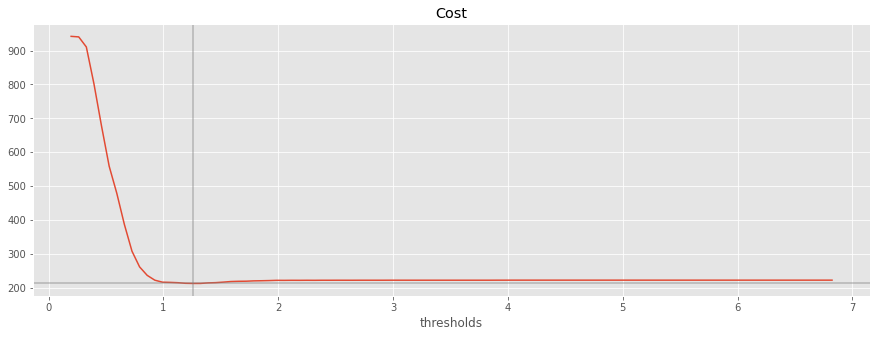

In [20]:
metrics.plot_cost(cmodel)


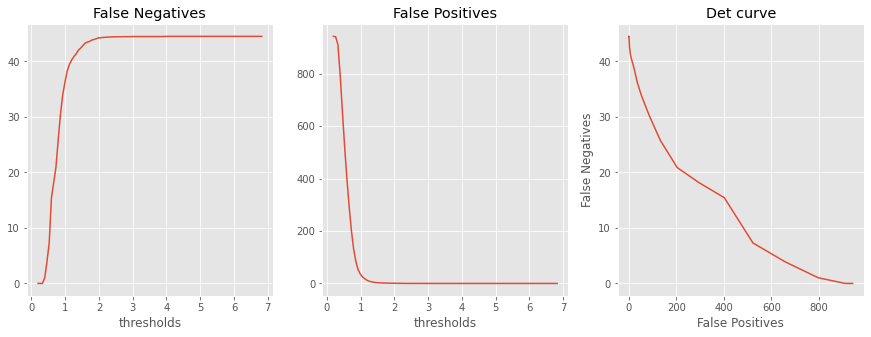

In [21]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


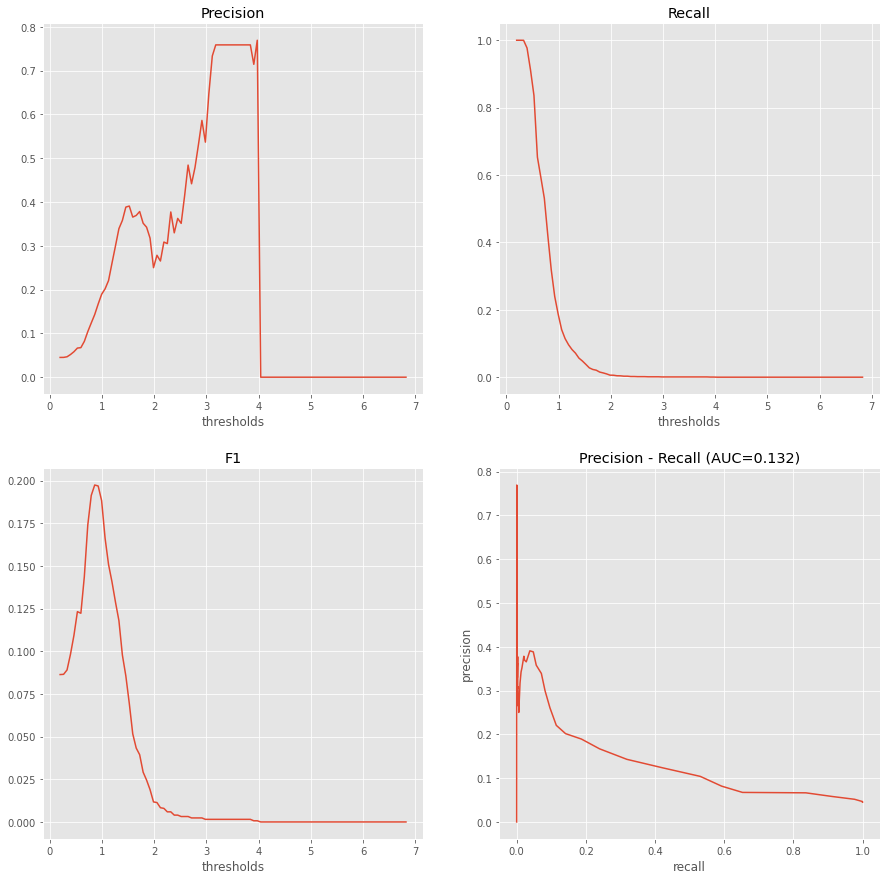

In [22]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)